# Comparison of skeleton and distmaps

Comparison is based on benchmarks.

Model trained on skeleton data with global main hyperparameters (n=75, beta=2, depth=3) but some had to be adapted (weight for crossentropy, batch size, learning rate)

In [8]:
import os
import sys
import json
import re
import pandas as pd
from tqdm import tqdm
from soma import aims
import random

# p = os.path.abspath('../')
# if p not in sys.path:
#     sys.path.append(p)
    
# q = os.path.abspath('../../')
# if q not in sys.path:
#     sys.path.append(q)
    
from vae import *
from preprocess import SkeletonDataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import dico_toolbox as dtx
import umap
from scipy.spatial import distance
from scipy.interpolate import interp1d
from scipy.stats import mannwhitneyu, ttest_ind, ks_2samp

from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.svm import LinearSVC

In [9]:
if torch.cuda.is_available():
    device = "cuda:0"

In [11]:
model_dir = '/neurospin/dico/lguillon/distmap/skel_comparison/w5_1e-4_rot_bs_32_1/checkpoint.pt'
model_vae = VAE((1, 80, 80, 96), 75, depth=3)
model_vae.load_state_dict(torch.load(model_dir))
model_vae = model_vae.to(device)

### Load data

#### HCP test

In [12]:
subject_dir = "/neurospin/dico/lguillon/distmap/data/"
data_dir = "/neurospin/dico/data/deep_folding/current/datasets/hcp/crops/1mm/SC/no_mask/Rcrops/"
test_list = pd.read_csv(os.path.join(subject_dir, "test_list.csv"))

skel = np.load(os.path.join(data_dir, "skel_test.npy"),
                   mmap_mode='r')
filenames = np.load(os.path.join(data_dir, "sub_id_skel_test.npy"))
print(skel.shape, filenames.shape)

subset = SkeletonDataset(dataframe=skel,
                         filenames=filenames,
                         data_transforms=False)
testloader = torch.utils.data.DataLoader(
               subset,
               batch_size=1,
               num_workers=1,
               shuffle=False)

(200, 78, 63, 88, 1) (200,)


#### Deletion benchmarks

In [13]:
data_dir = "/neurospin/dico/lguillon/distmap/benchmark/deletion"
data_path = "crops/1mm/SC"

skels_200 = np.load(os.path.join(data_dir, "200", data_path, "skel.npy"),
                   mmap_mode='r')
filenames_200 = np.load(os.path.join(data_dir, "200", data_path, "sub_id_skel.npy"))

subset_200 = SkeletonDataset(dataframe=skels_200,
                         filenames=filenames_200,
                         data_transforms=False)
loader_200 = torch.utils.data.DataLoader(
               subset_200,
               batch_size=1,
               num_workers=1,
               shuffle=False)

skels_500 = np.load(os.path.join(data_dir, "500", data_path, "skel.npy"),
                   mmap_mode='r')
filenames_500 = np.load(os.path.join(data_dir, "500", data_path, "sub_id_skel.npy"))

subset_500 = SkeletonDataset(dataframe=skels_500,
                         filenames=filenames_500,
                         data_transforms=False)
loader_500 = torch.utils.data.DataLoader(
               subset_500,
               batch_size=1,
               num_workers=1,
               shuffle=False)

skels_700 = np.load(os.path.join(data_dir, "700", data_path, "skel.npy"),
                   mmap_mode='r')
filenames_700 = np.load(os.path.join(data_dir, "700", data_path, "sub_id_skel.npy"))

subset_700 = SkeletonDataset(dataframe=skels_700,
                         filenames=filenames_700,
                         data_transforms=False)
loader_700 = torch.utils.data.DataLoader(
               subset_700,
               batch_size=1,
               num_workers=1,
               shuffle=False)

skels_1000 = np.load(os.path.join(data_dir, "1000", data_path, "skel.npy"),
                   mmap_mode='r')
filenames_1000 = np.load(os.path.join(data_dir, "1000", data_path, "sub_id_skel.npy"))

subset_1000 = SkeletonDataset(dataframe=skels_1000,
                         filenames=filenames_1000,
                         data_transforms=False)
loader_1000 = torch.utils.data.DataLoader(
               subset_1000,
               batch_size=1,
               num_workers=1,
               shuffle=False)

In [14]:
dico_set_loaders = {'hcp': testloader, '200': loader_200, '500': loader_500, '700': loader_700, '1000': loader_1000}

root_dir = '/neurospin/dico/lguillon/distmap/benchmark/results/'

weights = [1, 5]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='sum')
tester_deletion = ModelTester(model=model_vae, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=75, depth=3)

results_deletion = tester_deletion.test()
encoded_deletion = {loader_name:[results_deletion[loader_name][k][1] for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
losses_deletion = {loader_name:[int(results_deletion[loader_name][k][0].cpu().detach().numpy()) for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
recon_deletion = {loader_name:[int(results_deletion[loader_name][k][2].cpu().detach().numpy()) for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
input_deletion = {loader_name:[results_deletion[loader_name][k][3].cpu().detach().numpy() for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

hcp
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


In [15]:
df_encoded_hcp = pd.DataFrame()
df_encoded_hcp['latent'] = encoded_deletion['hcp']
df_encoded_hcp['loss'] = losses_deletion['hcp']  
df_encoded_hcp['recon'] = recon_deletion['hcp']   
df_encoded_hcp['input'] = input_deletion['hcp'] 
df_encoded_hcp['sub'] = list(filenames)
df_encoded_hcp['Group'] = ['hcp' for k in range(200)]

deletion_200 = pd.DataFrame()
deletion_200['latent'] = encoded_deletion['200']
deletion_200['loss'] = losses_deletion['200']  
deletion_200['recon'] = recon_deletion['200']   
deletion_200['input'] = input_deletion['200'] 
deletion_200['sub'] = list(filenames_200) 

deletion_500 = pd.DataFrame()
deletion_500['latent'] = encoded_deletion['500']  
deletion_500['loss'] = losses_deletion['500'] 
deletion_500['recon'] = recon_deletion['500']  
deletion_500['input'] = input_deletion['500']
deletion_500['sub'] = list(filenames_500)

deletion_700 = pd.DataFrame()
deletion_700['latent'] = encoded_deletion['700']  
deletion_700['loss'] = losses_deletion['700'] 
deletion_700['recon'] = recon_deletion['700']  
deletion_700['input'] = input_deletion['700']
deletion_700['sub'] = list(filenames_700)

deletion_1000 = pd.DataFrame()
deletion_1000['latent'] = encoded_deletion['1000']  
deletion_1000['loss'] = losses_deletion['1000'] 
deletion_1000['recon'] = recon_deletion['1000']  
deletion_1000['input'] = input_deletion['1000']
deletion_1000['sub'] = list(filenames_1000)

### 200

In [16]:
list_encoded_200 = random.sample(list(deletion_200['sub']), 90)
df_encoded_200_X = deletion_200[deletion_200['sub'].isin(list_encoded_200)]

list_ctrl = list(set(list(deletion_200['sub'])) - set(list(df_encoded_200_X['sub'])))
df_encoded_hcp_X_200 = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

In [17]:
X_200 = np.array(list(df_encoded_200_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X_200['latent']))
X_all = np.array(list(df_encoded_hcp_X_200['latent']) + list(df_encoded_200_X['latent']))

labels_200 = np.array(list(df_encoded_hcp_X_200['Group']) + ['200' for k in range(len(df_encoded_200_X))])
assert(len(X_200)==90)
assert(len(X_hcp)==90)

In [18]:
reducer = umap.UMAP()
embedding_200 = reducer.fit_transform(X_all)

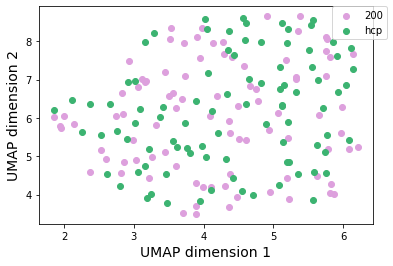

In [19]:
arr = embedding_200
color_dict = {'hcp':'mediumseagreen', '200': 'plum'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_200):
    ix = np.where(labels_200 == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

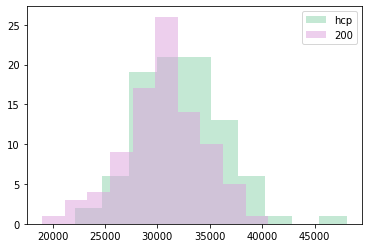

In [20]:
assert(len(df_encoded_hcp_X_200.recon)==90)
assert(len(df_encoded_200_X.recon)==90)
plt.subplot()
plt.hist(df_encoded_hcp_X_200.recon, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_200_X.recon, color='plum', alpha=0.5, label='200')
plt.legend()

In [21]:
F,p = mannwhitneyu(df_encoded_hcp_X_200.loss, df_encoded_200_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X_200.loss, df_encoded_200_X.loss)
print(p)

0.006911280374965719
0.047134419279858654


### 500

In [22]:
list_encoded_500 = random.sample(list(deletion_500['sub']), 34)
df_encoded_500_X = deletion_500[deletion_500['sub'].isin(list_encoded_500)]

list_ctrl = list(set(list(deletion_500['sub'])) - set(list(df_encoded_500_X['sub'])))
df_encoded_hcp_X_500 = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

In [23]:
X_500 = np.array(list(df_encoded_500_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X_500['latent']))
X_all = np.array(list(df_encoded_hcp_X_500['latent']) + list(df_encoded_500_X['latent']))

assert(len(X_500)==34)
assert(len(X_hcp)==34)

#X_embedded_500 = TSNE(n_components=2).fit_transform(X_all)
labels_500 = np.array(list(df_encoded_hcp_X_500['Group']) + ['500' for k in range(len(df_encoded_500_X))])
reducer = umap.UMAP()
embedding_500 = reducer.fit_transform(X_all)

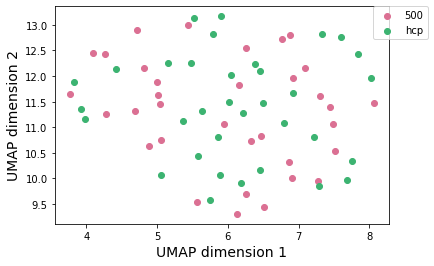

In [24]:
arr = embedding_500
color_dict = {'hcp':'mediumseagreen', '500': 'palevioletred'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_500):
    ix = np.where(labels_500 == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(0.95,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

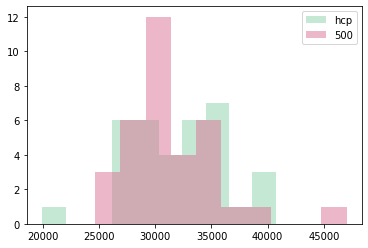

In [52]:
assert(len(df_encoded_hcp_X_500.recon)==34)
assert(len(df_encoded_500_X.recon)==34)
plt.subplot()
plt.hist(df_encoded_hcp_X_500.recon, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_500_X.recon, color='palevioletred', alpha=0.5, label='500')
plt.legend()

In [26]:
F,p = mannwhitneyu(df_encoded_hcp_X_500.loss, df_encoded_500_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X_500.loss, df_encoded_500_X.loss)
print(p)

0.1257260932540109
0.4222634523161909


### 700

In [27]:
list_encoded_700 = random.sample(list(deletion_700['sub']), 54)
df_encoded_700_X = deletion_700[deletion_700['sub'].isin(list_encoded_700)]

list_ctrl = list(set(list(deletion_700['sub'])) - set(list(df_encoded_700_X['sub'])))
df_encoded_hcp_X_700 = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

In [28]:
X_700 = np.array(list(df_encoded_700_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X_700['latent']))
X_all = np.array(list(df_encoded_hcp_X_700['latent']) + list(df_encoded_700_X['latent']))

assert(len(X_700)==54)
assert(len(X_hcp)==54)

#X_embedded_700 = TSNE(n_components=2).fit_transform(X_all)
labels_700 = np.array(list(df_encoded_hcp_X_700['Group']) + ['700' for k in range(len(df_encoded_700_X))])
reducer = umap.UMAP()
embedding_700 = reducer.fit_transform(X_all)

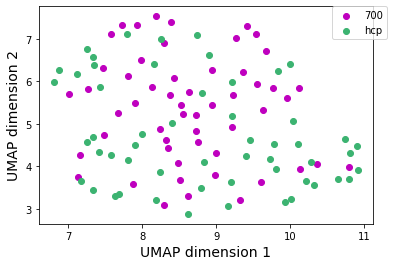

In [53]:
arr = embedding_700
color_dict = {'hcp':'mediumseagreen', '700': 'm'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_700):
    ix = np.where(labels_700 == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

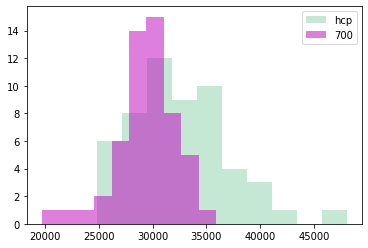

In [54]:
assert(len(df_encoded_hcp_X_700.recon)==54)
assert(len(df_encoded_700_X.recon)==54)
plt.subplot()
plt.hist(df_encoded_hcp_X_700.recon, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_700_X.recon, color='m', alpha=0.5, label='700')
plt.legend()

In [55]:
F,p = mannwhitneyu(df_encoded_hcp_X_700.loss, df_encoded_700_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X_700.loss, df_encoded_700_X.loss)
print(p)

9.241251442788321e-05
0.0003622077093319878


### 1000

In [32]:
list_encoded_1000 = random.sample(list(deletion_1000['sub']), 75)
df_encoded_1000_X = deletion_1000[deletion_1000['sub'].isin(list_encoded_1000)]

list_ctrl = list(set(list(deletion_1000['sub'])) - set(list(df_encoded_1000_X['sub'])))
df_encoded_hcp_X_1000 = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

In [33]:
X_1000 = np.array(list(df_encoded_1000_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X_1000['latent']))
X_all = np.array(list(df_encoded_hcp_X_1000['latent']) + list(df_encoded_1000_X['latent']))

assert(len(X_1000)==75)
assert(len(X_hcp)==76)

#X_embedded_1000 = TSNE(n_components=2, perplexity=15).fit_transform(X_all)
labels_1000 = np.array(list(df_encoded_hcp_X_1000['Group']) + ['1000' for k in range(len(df_encoded_1000_X))])
reducer = umap.UMAP()
embedding_1000 = reducer.fit_transform(X_all)

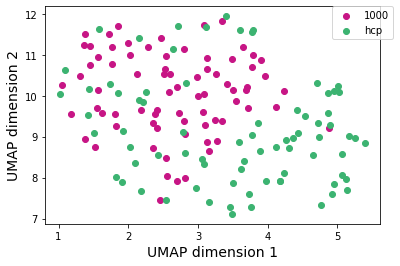

In [34]:
arr = embedding_1000
color_dict = {'hcp':'mediumseagreen', '1000': 'mediumvioletred'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_1000):
    ix = np.where(labels_1000 == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

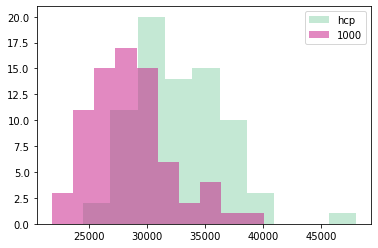

In [56]:
assert(len(df_encoded_hcp_X_1000.recon)==76)
assert(len(df_encoded_1000_X.recon)==75)
plt.subplot()
plt.hist(df_encoded_hcp_X_1000.recon, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_1000_X.recon, color='mediumvioletred', alpha=0.5, label='1000')
plt.legend()

In [57]:
F,p = mannwhitneyu(df_encoded_hcp_X_1000.loss, df_encoded_1000_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X_1000.loss, df_encoded_1000_X.loss)
print(p)

7.803707851025047e-11
7.510992307353255e-09


## Quantification

### 200

In [66]:
X_200 = np.array(list(df_encoded_200_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X_200['latent']))

X = np.array(list(df_encoded_hcp_X_200['latent']) + list(df_encoded_200_X['latent']))
label = np.array(['hcp' for k in range(len(X_hcp))] + ['200' for k in range(len(X_200))])

X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.4, stratify=label, random_state=42)

>acc=0.472, est=0.542, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.611, est=0.535, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.667, est=0.541, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.583, est=0.569, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.694, est=0.569, cfg={'C': 1.2, 'penalty': 'l2'}


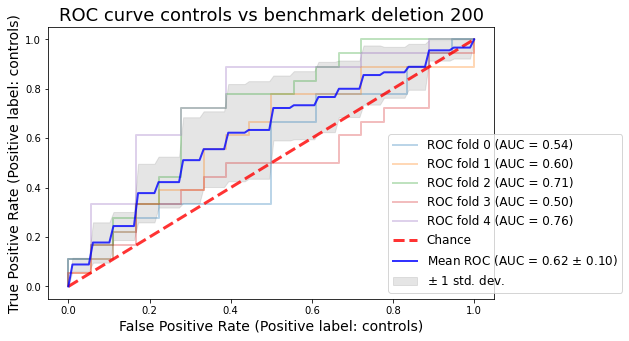

Accuracy: 0.606 (0.077)


In [67]:
fig, ax = plt.subplots(figsize=(8, 5))

cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
i = 0

for train_ix, test_ix in cv_outer.split(X, label):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = label[train_ix], label[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = LinearSVC(random_state=1, loss='squared_hinge', max_iter=10000)
    space = dict()
    space['penalty'] = ['l2']
    space['C'] = [0.7, 1, 1.2]
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = metrics.accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        
    viz = metrics.plot_roc_curve(best_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    i+=1
    
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large', bbox_to_anchor=(1.3, 0))
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark deletion 200', fontsize=18)
plt.show()
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

### 500

In [60]:
X_500 = np.array(list(df_encoded_500_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X_500['latent']))
X = np.array(list(df_encoded_hcp_X_500['latent']) + list(df_encoded_500_X['latent']))

#X_embedded_500 = TSNE(n_components=2).fit_transform(X_all)
label = np.array(list(df_encoded_hcp_X_500['Group']) + ['500' for k in range(len(df_encoded_500_X))])

>acc=0.714, est=0.524, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.714, est=0.631, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.643, est=0.631, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.692, est=0.636, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.615, est=0.582, cfg={'C': 0.7, 'penalty': 'l2'}


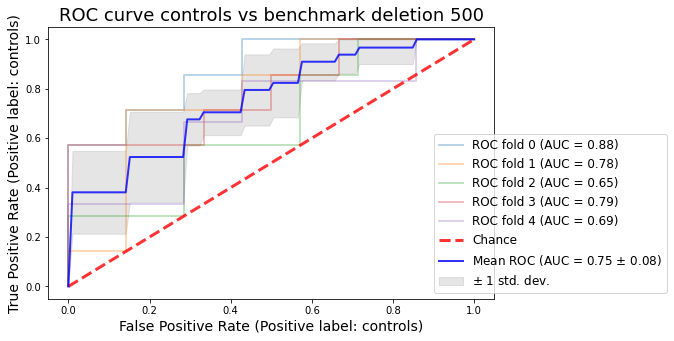

Accuracy: 0.676 (0.040)


In [61]:
fig, ax = plt.subplots(figsize=(8, 5))

cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
i = 0


for train_ix, test_ix in cv_outer.split(X, label):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = label[train_ix], label[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = LinearSVC(random_state=1, loss='squared_hinge', max_iter=10000)
    space = dict()
    space['penalty'] = ['l2']
    space['C'] = [0.7, 1, 1.2]
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = metrics.accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        
    viz = metrics.plot_roc_curve(best_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    
    i+=1

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large', bbox_to_anchor=(1.4, 0))
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark deletion 500', fontsize=18)
plt.show()
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

### 700

In [62]:
X_700 = np.array(list(df_encoded_700_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X_700['latent']))
X = np.array(list(df_encoded_hcp_X_700['latent']) + list(df_encoded_700_X['latent']))

label = np.array(list(df_encoded_hcp_X_700['Group']) + ['700' for k in range(len(df_encoded_700_X))])

>acc=0.636, est=0.571, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.682, est=0.569, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.409, est=0.603, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.714, est=0.595, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.571, est=0.642, cfg={'C': 0.7, 'penalty': 'l2'}


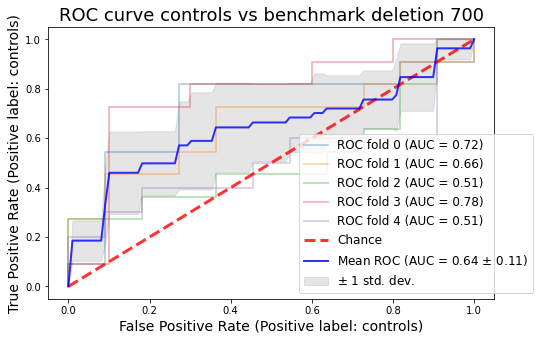

Accuracy: 0.603 (0.108)


In [63]:
fig, ax = plt.subplots(figsize=(8, 5))

cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
i = 0

for train_ix, test_ix in cv_outer.split(X, label):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = label[train_ix], label[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = LinearSVC(random_state=1, loss='squared_hinge', max_iter=10000)
    space = dict()
    space['penalty'] = ['l2']
    space['C'] = [0.7, 1, 1.2]
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = metrics.accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        
    viz = metrics.plot_roc_curve(best_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    i += 1
    
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large', bbox_to_anchor=(1.1, 0))
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark deletion 700', fontsize=18)
plt.show()
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

### 1000

In [64]:
X_1000 = np.array(list(df_encoded_1000_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X_1000['latent']))
X = np.array(list(df_encoded_hcp_X_1000['latent']) + list(df_encoded_1000_X['latent']))

label = np.array(list(df_encoded_hcp_X_1000['Group']) + ['1000' for k in range(len(df_encoded_1000_X))])

>acc=0.710, est=0.775, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.867, est=0.727, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.833, est=0.761, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.767, est=0.843, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.867, est=0.793, cfg={'C': 0.7, 'penalty': 'l2'}


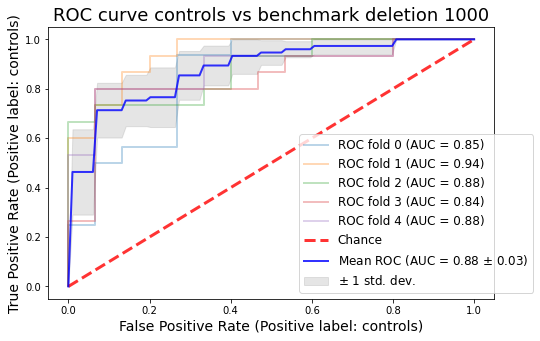

Accuracy: 0.809 (0.061)


In [65]:
fig, ax = plt.subplots(figsize=(8, 5))

cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
i = 0

for train_ix, test_ix in cv_outer.split(X, label):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = label[train_ix], label[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = LinearSVC(random_state=1, loss='squared_hinge', max_iter=10000)
    space = dict()
    space['penalty'] = ['l2']
    space['C'] = [0.7, 1, 1.2]
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = metrics.accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        
    viz = metrics.plot_roc_curve(best_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    i += 1
    
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large', bbox_to_anchor=(1.1, 0))
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark deletion 1000', fontsize=18)
plt.show()
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

## Asymmetry

In [68]:
data_dir = '/neurospin/dico/lguillon/distmap/benchmark/asymmetry/'

In [69]:
skels_asym = np.load(os.path.join(data_dir, "skel.npy"),
                   mmap_mode='r')
filenames_asym = np.load(os.path.join(data_dir, "sub_id_skel.npy"))

subset_asym = SkeletonDataset(dataframe=skels_asym,
                         filenames=filenames_asym,
                         data_transforms=False)
loader_asym = torch.utils.data.DataLoader(
               subset_asym,
               batch_size=1,
               num_workers=1,
               shuffle=False)

In [70]:
dico_set_loaders = {'asymmetry': loader_asym}

root_dir = '/neurospin/dico/lguillon/distmap/benchmark/results/'

weights = [1, 5]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='sum')
tester_asym = ModelTester(model=model_vae, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=75, depth=3)

results_asym = tester_asym.test()
encoded_asym = {loader_name:[results_asym[loader_name][k][1] for k in results_asym[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
losses_asym = {loader_name:[int(results_asym[loader_name][k][0].cpu().detach().numpy()) for k in results_asym[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
recon_asym = {loader_name:[int(results_asym[loader_name][k][2].cpu().detach().numpy()) for k in results_asym[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
input_asym = {loader_name:[results_asym[loader_name][k][3].cpu().detach().numpy() for k in results_asym[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

asymmetry
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


In [71]:
df_encoded_asym = pd.DataFrame()
df_encoded_asym['latent'] = encoded_asym['asymmetry']
df_encoded_asym['loss'] = losses_asym['asymmetry']  
df_encoded_asym['recon'] = recon_asym['asymmetry']   
df_encoded_asym['input'] = input_asym['asymmetry'] 
df_encoded_asym['sub'] = list(filenames_asym) 

In [72]:
random.seed(a=12)
list_encoded_asym = random.sample(list(df_encoded_asym['sub']), 100)
df_encoded_asym_X = df_encoded_asym[df_encoded_asym['sub'].isin(list_encoded_asym)]

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_asym_X['sub'])))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

X_asym = np.array(list(df_encoded_asym_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X['latent']))
X_all = np.array(list(df_encoded_hcp_X['latent']) + list(df_encoded_asym_X['latent']))

labels_asym = np.array(list(df_encoded_hcp_X['Group']) + ['asymmetry' for k in range(len(df_encoded_asym_X))])
reducer = umap.UMAP(random_state=14)
embedding_asym = reducer.fit_transform(X_all)

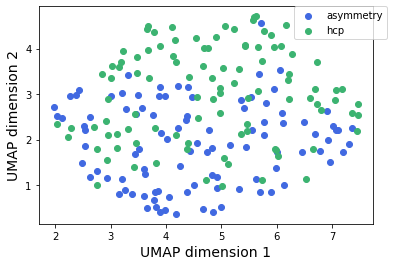

In [73]:
arr = embedding_asym
color_dict = {'hcp':'mediumseagreen', 'asymmetry': 'royalblue'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_asym):
    ix = np.where(labels_asym == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
# ax.scatter(centeroidnp(embedding_asym[:100])[0], 
#            centeroidnp(embedding_asym[:100])[1], c='mediumseagreen', marker='x')
# ax.scatter(centeroidnp(embedding_asym[100:])[0],
#            centeroidnp(embedding_asym[100:])[1], c='royalblue', marker='x')

# for i, txt in enumerate(list(df_encoded_asym_X['sub'])):
#     if txt=='887373':
#         ax.annotate(txt, (embedding_asym[100:][i][0], embedding_asym[100:][i][1]))
# for i, txt in enumerate(list(df_encoded_hcp_X['sub'])):
#     if txt==844961:
#         ax.annotate(txt, (embedding_asym[:100][i][0], embedding_asym[:100][i][1]))
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

### Average Patterns

In [43]:
tgt_dir = '/neurospin/dico/lguillon/distmap/skel_comparison/'

In [44]:
enc_asym = np.array([np.mean([X_asym[k][i] for k in range(len(X_asym))]) for i in range(75)])
enc_hcp = np.array([np.mean([X_hcp[k][i] for k in range(len(X_hcp))]) for i in range(75)])

In [47]:
z = torch.from_numpy(np.array(enc_asym)).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model_vae.decode(z)
out = torch.argmax(out, dim=1)
out = np.array(np.squeeze(out).cpu().detach().numpy())

aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), 
                                                      voxel_size=(1,1,1)), 
            f"{tgt_dir}asym_bucket.bck")

aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(out)), 
            f"{tgt_dir}asym_mesh.mesh")

In [48]:
enc_hcp = np.array([np.mean([np.array(df_encoded_hcp_X.latent)[k][i] for k in range(100)]) for i in range(75)])

In [49]:
z = torch.from_numpy(np.array(enc_hcp)).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model_vae.decode(z)
out = torch.argmax(out, dim=1)
out = np.array(np.squeeze(out).cpu().detach().numpy())

#np.save('out_ctrl.npy', out)

aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), 
                                                      voxel_size=(1,1,1)), 
            f"{tgt_dir}ctrl_bucket.bck")

aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(out)), 
            f"{tgt_dir}ctrl_mesh.mesh")

### Reconstructions

In [51]:
z_ctrl = df_encoded_hcp_X[df_encoded_hcp_X['sub']=='127832'].latent.values[0]

z = torch.from_numpy(np.array(z_ctrl)).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model_vae.decode(z)
out = torch.argmax(out, dim=1)
out = np.array(np.squeeze(out).cpu().detach().numpy())

aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), 
                                                      voxel_size=(1,1,1)), 
            f"{tgt_dir}ctrl_bucket_127832.bck")

aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(out)), 
            f"{tgt_dir}ctrl_mesh_127832.mesh")

In [7]:
for inputs, path in testloader:
    #print("==========================VAL==============")
    with torch.no_grad():
        inputs = Variable(inputs).to(device, dtype=torch.float32)
        output, z, logvar = model_vae(inputs)
        target = torch.squeeze(inputs, dim=1).long()
        recon_loss_val, kl_val, loss = vae_loss(output, target, z,
                                        logvar, criterion,
                                        kl_weight=2)
        output = torch.argmax(output, dim=1)
        out = np.array(np.squeeze(output).cpu().detach().numpy())
        np.save(f"reconstruction_ctrl_{path}.npy", out)

KeyboardInterrupt: 

In [128]:
np.random.seed(1)
src_dir = '/neurospin/dico/data/deep_folding/current/datasets/hcp/crops/1mm/SC/no_mask'
filenames = np.load(os.path.join(src_dir, 'Rcrops',
                                "sub_id_skel.npy"))
skeletons = np.load(os.path.join(src_dir, 'Rcrops',
                                "skel.npy"),
                   mmap_mode='r')

indices = list(range(len(filenames)))
np.random.shuffle(indices)
split = int(np.floor(0.8 * len(filenames)))
train_idx, val_idx = indices[:split], indices[split:]
train_skel, train_filenames = skeletons[train_idx], filenames[train_idx]
val_skel, val_filenames = skeletons[val_idx], filenames[val_idx]

train_set = SkeletonDataset(dataframe=train_skel,
                            filenames=train_filenames,
                            data_transforms=True)
val_set = SkeletonDataset(dataframe=val_skel,
                          filenames=val_filenames,
                          data_transforms=False)

/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 506, in fit
    sample_weight_val, begin_at_stage, monitor)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 563, in _fit_stages
    random_state, X_csc, X_csr)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 215, in _fit_stage
    check_input=False)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/casa/home/.local/lib/pyt

/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 506, in fit
    sample_weight_val, begin_at_stage, monitor)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 563, in _fit_stages
    random_state, X_csc, X_csr)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 215, in _fit_stage
    check_input=False)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/casa/home/.local/lib/pyt

/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.7375  0.75625 0.775   0.79375 0.76875 0.7875  0.7875  0.80625 0.775
 0.7875  0.8     0.80625 0.7625  0.8     0.83125 0.80625 0.78125 0.78125
 0.775   0.775   0.78125 0.76875 0.7875  0.8     0.80625 0.8125  0.825
 0.825   0.79375 0.8125  0.8     0.8125      nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan 0.73125 0.75    0.78125 0.79375 0.76875 0.7875  0.7875  0.80625
 0.775   0.7875  0.8     0.80625 0.76875 0.80625 0.83125 0.80625 0.7875
 0.78125 0.78125 0.78125 0.7875  0.76875 0.7875  0.8     0.8     0.8125
 0.825   0.81875 0.7875  0.8125  0.80625 0.8125 ]
  category=UserWarning


>acc=0.750, est=0.831, cfg={'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 100}


/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 506, in fit
    sample_weight_val, begin_at_stage, monitor)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 563, in _fit_stages
    random_state, X_csc, X_csr)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 215, in _fit_stage
    check_input=False)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/casa/home/.local/lib/pyt

/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 506, in fit
    sample_weight_val, begin_at_stage, monitor)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 563, in _fit_stages
    random_state, X_csc, X_csr)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 215, in _fit_stage
    check_input=False)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/casa/home/.local/lib/pyt

/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.675   0.7125  0.725   0.75    0.65625 0.69375 0.70625 0.725   0.70625
 0.7375  0.71875 0.71875 0.71875 0.73125 0.71875 0.7125  0.7     0.74375
 0.74375 0.74375 0.6875  0.71875 0.7     0.73125 0.7125  0.6875  0.71875
 0.7375  0.7375  0.74375 0.7625  0.7375      nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan 0.675   0.70625 0.71875 0.75    0.65625 0.69375 0.70625 0.73125
 0.7125  0.74375 0.71875 0.71875 0.7125  0.73125 0.70625 0.71875 0.7
 0.7375  0.74375 0.74375 0.68125 0.7125  0.69375 0.725   0.7125  0.6875
 0.71875 0.7375  0.7375  0.7375  0.75625 0.73125]
  category=UserWarning


>acc=0.825, est=0.762, cfg={'criterion': 'friedman_mse', 'learning_rate': 0.25, 'loss': 'exponential', 'n_estimators': 100}


/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 506, in fit
    sample_weight_val, begin_at_stage, monitor)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 563, in _fit_stages
    random_state, X_csc, X_csr)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 215, in _fit_stage
    check_input=False)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/casa/home/.local/lib/pyt

/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 506, in fit
    sample_weight_val, begin_at_stage, monitor)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 563, in _fit_stages
    random_state, X_csc, X_csr)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 215, in _fit_stage
    check_input=False)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/casa/home/.local/lib/pyt

/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.6875  0.70625 0.73125 0.73125 0.6875  0.6875  0.725   0.725   0.71875
 0.7125  0.73125 0.73125 0.66875 0.71875 0.71875 0.74375 0.74375 0.74375
 0.75    0.75    0.73125 0.74375 0.71875 0.74375 0.74375 0.74375 0.7625
 0.7375  0.725   0.75625 0.7375  0.725       nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan 0.6875  0.70625 0.73125 0.73125 0.69375 0.6875  0.725   0.725
 0.71875 0.7125  0.73125 0.73125 0.66875 0.71875 0.71875 0.74375 0.74375
 0.74375 0.74375 0.75    0.7375  0.74375 0.71875 0.74375 0.74375 0.73125
 0.75625 0.7375  0.71875 0.75625 0.7375  0.73125]
  category=UserWarning


>acc=0.850, est=0.762, cfg={'criterion': 'friedman_mse', 'learning_rate': 0.25, 'loss': 'deviance', 'n_estimators': 100}


/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 506, in fit
    sample_weight_val, begin_at_stage, monitor)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 563, in _fit_stages
    random_state, X_csc, X_csr)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 215, in _fit_stage
    check_input=False)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/casa/home/.local/lib/pyt

/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 506, in fit
    sample_weight_val, begin_at_stage, monitor)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 563, in _fit_stages
    random_state, X_csc, X_csr)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 215, in _fit_stage
    check_input=False)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/casa/home/.local/lib/pyt

/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.74375 0.76875 0.7625  0.7625  0.7375  0.7375  0.74375 0.775   0.7875
 0.78125 0.775   0.78125 0.78125 0.775   0.775   0.78125 0.79375 0.775
 0.79375 0.7875  0.8     0.8125  0.8     0.79375 0.76875 0.775   0.78125
 0.775   0.775   0.775   0.7625  0.7625      nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan 0.7375  0.7625  0.7625  0.76875 0.7375  0.7375  0.74375 0.7875
 0.79375 0.79375 0.78125 0.78125 0.78125 0.775   0.76875 0.78125 0.775
 0.76875 0.7875  0.7875  0.8     0.8125  0.8     0.79375 0.76875 0.775
 0.78125 0.775   0.775   0.775   0.7625  0.76875]
  category=UserWarning


>acc=0.800, est=0.812, cfg={'criterion': 'friedman_mse', 'learning_rate': 0.2, 'loss': 'exponential', 'n_estimators': 75}


/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 506, in fit
    sample_weight_val, begin_at_stage, monitor)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 563, in _fit_stages
    random_state, X_csc, X_csr)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 215, in _fit_stage
    check_input=False)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/casa/home/.local/lib/pyt

/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 506, in fit
    sample_weight_val, begin_at_stage, monitor)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 563, in _fit_stages
    random_state, X_csc, X_csr)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 215, in _fit_stage
    check_input=False)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/casa/home/.local/lib/pyt

/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.75    0.8     0.8     0.7625  0.71875 0.775   0.76875 0.775   0.79375
 0.8     0.8     0.8     0.8     0.7875  0.8     0.78125 0.73125 0.75
 0.75    0.7625  0.76875 0.775   0.78125 0.75625 0.78125 0.76875 0.775
 0.80625 0.775   0.8     0.8     0.8         nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan 0.75    0.8     0.8     0.7625  0.73125 0.78125 0.775   0.775
 0.79375 0.7875  0.78125 0.7875  0.8     0.7875  0.8     0.7875  0.73125
 0.74375 0.75625 0.75    0.76875 0.775   0.78125 0.75625 0.78125 0.76875
 0.775   0.80625 0.76875 0.8     0.8     0.8    ]
  category=UserWarning


>acc=0.700, est=0.806, cfg={'criterion': 'friedman_mse', 'learning_rate': 0.25, 'loss': 'deviance', 'n_estimators': 150}


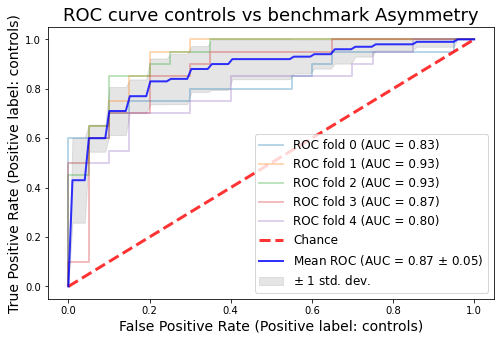

Accuracy: 0.785 (0.054)


In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_all, labels_asym, test_size=0.4, stratify=labels_asym, random_state=42)

fig, ax = plt.subplots(figsize=(8, 5))

cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
i = 0

for train_ix, test_ix in cv_outer.split(X_all, labels_asym):
    X_train, X_test = X_all[train_ix, :], X_all[test_ix, :]
    y_train, y_test = labels_asym[train_ix], labels_asym[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = GradientBoostingClassifier(random_state=1)
    space = dict()
    space['loss'] = ['deviance', 'exponential']
    space['learning_rate'] = [0.05, 0.1, 0.2, 0.25]
    space['n_estimators'] = [50, 75, 100, 150]
    space['criterion'] = ['friedman_mse', 'squared_error', 'mse']
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = metrics.accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        
    viz = metrics.plot_roc_curve(best_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    i += 1 
    
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large')
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark Asymmetry', fontsize=18)
plt.show()
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

## Loss

In [75]:
list_encoded_asym = random.sample(list(df_encoded_asym['sub']), 100)
df_encoded_asym_X = df_encoded_asym[df_encoded_asym['sub'].isin(list_encoded_asym)]

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_asym_X['sub'])))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

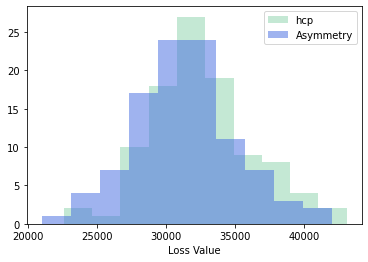

In [76]:
plt.subplot()
plt.hist(df_encoded_hcp_X.loss, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_asym_X.loss, color='royalblue', alpha=0.5, label='Asymmetry') 
plt.xlabel('Loss Value')
plt.legend()

In [77]:
F,p = mannwhitneyu(df_encoded_hcp_X.loss, df_encoded_asym_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X.loss, df_encoded_asym_X.loss)
print(p)

0.014829386888798887
0.19304165192468994


## Left-handers

In [78]:
### Loading of subjects
handedness = pd.read_csv('/neurospin/dico/lguillon/hcp_info/handedness.csv')

In [79]:
left_info = pd.DataFrame(handedness[handedness.Handedness<=-10][['Subject', 'Handedness']].values, columns=['subjects', 'handedness_score'])
left_info.subjects = left_info.subjects.astype(str)
print(len(left_info))

108


In [80]:
list_left = np.array(list(left_info.subjects))
print(len(list_left))

filenames = np.load('/neurospin/dico/data/deep_folding/current/datasets/hcp/crops/1mm/SC/no_mask/Rcrops/sub_id_skel_all.npy')
skels = np.load('/neurospin/dico/data/deep_folding/current/datasets/hcp/crops/1mm/SC/no_mask/Rcrops/skel_all.npy', mmap_mode='r')

print(len(left_info))

sorter = np.argsort(filenames)
filenames_idx = sorter[np.searchsorted(filenames, list(left_info.subjects), sorter=sorter)]
filenames = filenames[filenames_idx]
skels = skels[filenames_idx]

filenames_df = pd.DataFrame(list(filenames), columns=['subjects'])

print(skels.shape, filenames.shape)

subset = SkeletonDataset(dataframe=skels,
                         filenames=filenames,
                         data_transforms=False)

108
108
(108, 78, 63, 88, 1) (108,)


In [81]:
left_loader = torch.utils.data.DataLoader(
               subset,
               batch_size=1,
               num_workers=1,
               shuffle=False)

dico_set_loaders = {'left_handers': left_loader}

root_dir = '/neurospin/dico/lguillon/distmap/benchmark/results/'

weights = [1, 5]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='sum')
tester_left = ModelTester(model=model_vae, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=75, depth=3)

results_left = tester_left.test()
encoded_left = {loader_name:[results_left[loader_name][k][1] for k in results_left[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
losses_left = {loader_name:[int(results_left[loader_name][k][0].cpu().detach().numpy()) for k in results_left[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
recon_left = {loader_name:[int(results_left[loader_name][k][2].cpu().detach().numpy()) for k in results_left[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
input_left = {loader_name:[results_left[loader_name][k][3].cpu().detach().numpy() for k in results_left[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

left_handers
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


In [82]:
df_encoded_left = pd.DataFrame()
df_encoded_left['latent'] = encoded_left['left_handers']
df_encoded_left['loss'] = losses_left['left_handers']  
df_encoded_left['recon'] = recon_left['left_handers']   
df_encoded_left['input'] = input_left['left_handers'] 
df_encoded_left['sub'] = np.unique(filenames)

In [88]:
random.seed(a=12)

df_encoded_hcp_X = df_encoded_hcp

X_left = np.array(list(df_encoded_left['latent']))
X_hcp = np.array(list(df_encoded_hcp_X['latent']))
X_all = np.array(list(df_encoded_left['latent']) + list(df_encoded_hcp_X['latent']))

labels_left = np.array(['left_handers' for k in range(len(df_encoded_left))] + list(df_encoded_hcp_X['Group']))
reducer = umap.UMAP(random_state=0)
embedding_left = reducer.fit_transform(X_all)

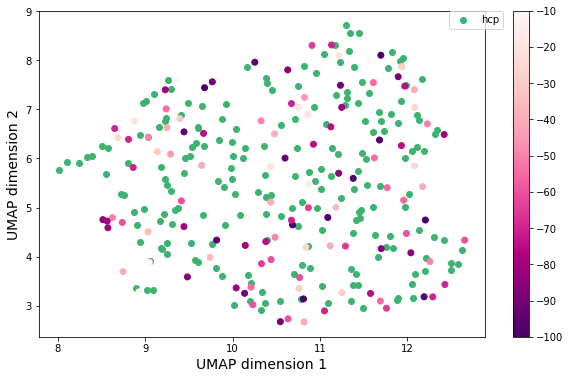

In [89]:
import matplotlib.cm as cm

arr = embedding_left
color_dict = {'hcp':'mediumseagreen', 'left_handers': 'orange'}

fig = plt.figure(figsize=(10, 6))
ax = fig.subplots()

for g in np.unique(labels_left):
    ix = np.where(labels_left == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    if g == 'left_handers':
        t = np.array(list(left_info.handedness_score))[ix]
        ax.scatter(x, y, c=t, cmap='RdPu_r')
    else:
        ax.scatter(x, y, c = 'mediumseagreen', label = g_lab)

map1 = ax1.imshow(np.stack([t, t]),cmap='RdPu_r')
fig.colorbar(map1, ax=ax)

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 506, in fit
    sample_weight_val, begin_at_stage, monitor)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 563, in _fit_stages
    random_state, X_csc, X_csr)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 215, in _fit_stage
    check_input=False)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/casa/home/.local/lib/pyt

/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 506, in fit
    sample_weight_val, begin_at_stage, monitor)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 563, in _fit_stages
    random_state, X_csc, X_csr)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 215, in _fit_stage
    check_input=False)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/casa/home/.local/lib/pyt

/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.56326531 0.59183673 0.58367347 0.6122449  0.5755102  0.5877551
 0.58367347 0.60408163 0.59591837 0.59183673 0.6122449  0.60408163
 0.61632653 0.61632653 0.60408163 0.60816327 0.62040816 0.59591837
 0.6        0.5877551  0.6        0.6122449  0.60408163 0.60408163
 0.59183673 0.57959184 0.58367347 0.55918367 0.62857143 0.6
 0.60816327 0.60408163        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.57142857 0.59591837
 0.5877551  0.61632653 0.5755102  0.5877551  0.58367347 0.60408163
 0.6        0.59183673 0.60816327 0.60408163 0.61632653 0.

>acc=0.677, est=0.637, cfg={'criterion': 'mse', 'learning_rate': 0.25, 'loss': 'exponential', 'n_estimators': 50}


/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 506, in fit
    sample_weight_val, begin_at_stage, monitor)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 563, in _fit_stages
    random_state, X_csc, X_csr)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 215, in _fit_stage
    check_input=False)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/casa/home/.local/lib/pyt

/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 506, in fit
    sample_weight_val, begin_at_stage, monitor)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 563, in _fit_stages
    random_state, X_csc, X_csr)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 215, in _fit_stage
    check_input=False)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/casa/home/.local/lib/pyt

/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.63673469 0.63673469 0.62040816 0.61632653 0.64897959 0.64081633
 0.64081633 0.6244898  0.61632653 0.61632653 0.6122449  0.59183673
 0.65714286 0.63265306 0.61632653 0.6        0.6122449  0.57142857
 0.6        0.6        0.60816327 0.61632653 0.60408163 0.59183673
 0.62040816 0.59591837 0.60816327 0.6122449  0.57959184 0.60408163
 0.6244898  0.60816327        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.62857143 0.62857143
 0.61632653 0.61632653 0.64897959 0.64081633 0.64081633 0.6244898
 0.62040816 0.62040816 0.61632653 0.6        0.6653

>acc=0.645, est=0.665, cfg={'criterion': 'mse', 'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 50}


/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 506, in fit
    sample_weight_val, begin_at_stage, monitor)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 563, in _fit_stages
    random_state, X_csc, X_csr)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 215, in _fit_stage
    check_input=False)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/casa/home/.local/lib/pyt

/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 506, in fit
    sample_weight_val, begin_at_stage, monitor)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 563, in _fit_stages
    random_state, X_csc, X_csr)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 215, in _fit_stage
    check_input=False)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/casa/home/.local/lib/pyt

/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.61379592 0.60163265 0.60563265 0.58938776 0.64636735 0.62612245
 0.60987755 0.60971429 0.60163265 0.58955102 0.59355102 0.57746939
 0.60963265 0.58930612 0.60138776 0.60538776 0.60155102 0.60155102
 0.61379592 0.61387755 0.61820408 0.61404082 0.61820408 0.60171429
 0.60995918 0.61395918 0.60979592 0.61412245 0.64220408 0.61771429
 0.58146939 0.58538776        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.61787755 0.60571429
 0.60571429 0.58946939 0.64636735 0.62612245 0.60987755 0.60971429
 0.59755102 0.59355102 0.59363265 0.57746939 0.605

>acc=0.574, est=0.646, cfg={'criterion': 'friedman_mse', 'learning_rate': 0.05, 'loss': 'exponential', 'n_estimators': 50}


/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 506, in fit
    sample_weight_val, begin_at_stage, monitor)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 563, in _fit_stages
    random_state, X_csc, X_csr)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 215, in _fit_stage
    check_input=False)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/casa/home/.local/lib/pyt

/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 506, in fit
    sample_weight_val, begin_at_stage, monitor)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 563, in _fit_stages
    random_state, X_csc, X_csr)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 215, in _fit_stage
    check_input=False)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/casa/home/.local/lib/pyt

/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.59738776 0.59330612 0.58514286 0.57297959 0.62179592 0.61371429
 0.58930612 0.57306122 0.59738776 0.60146939 0.60963265 0.62195918
 0.61779592 0.61787755 0.61379592 0.62187755 0.57730612 0.59371429
 0.60579592 0.60579592 0.60555102 0.60138776 0.60563265 0.60155102
 0.60571429 0.60171429 0.59346939 0.59755102 0.61795918 0.60987755
 0.62212245 0.63828571        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.59738776 0.59330612
 0.58922449 0.57706122 0.62187755 0.60555102 0.59338776 0.57306122
 0.59738776 0.60555102 0.60555102 0.61787755 0.609

>acc=0.541, est=0.638, cfg={'criterion': 'friedman_mse', 'learning_rate': 0.25, 'loss': 'exponential', 'n_estimators': 150}


/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 506, in fit
    sample_weight_val, begin_at_stage, monitor)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 563, in _fit_stages
    random_state, X_csc, X_csr)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 215, in _fit_stage
    check_input=False)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/casa/home/.local/lib/pyt

/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 506, in fit
    sample_weight_val, begin_at_stage, monitor)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 563, in _fit_stages
    random_state, X_csc, X_csr)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/ensemble/_gb.py", line 215, in _fit_stage
    check_input=False)
  File "/casa/home/.local/lib/python3.6/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/casa/home/.local/lib/pyt

/casa/home/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.62195918 0.62187755 0.60971429 0.60563265 0.60979592 0.62195918
 0.61795918 0.61379592 0.63004082 0.62995918 0.63012245 0.62187755
 0.63436735 0.63428571 0.63436735 0.63828571 0.61004082 0.60995918
 0.62204082 0.61404082 0.61395918 0.60979592 0.62620408 0.61404082
 0.61387755 0.61795918 0.62595918 0.64636735 0.62228571 0.63012245
 0.64253061 0.63428571        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.62195918 0.62187755
 0.61379592 0.60563265 0.60979592 0.62195918 0.62204082 0.61787755
 0.62595918 0.62187755 0.63012245 0.61779592 0.634

>acc=0.525, est=0.650, cfg={'criterion': 'mse', 'learning_rate': 0.25, 'loss': 'deviance', 'n_estimators': 150}


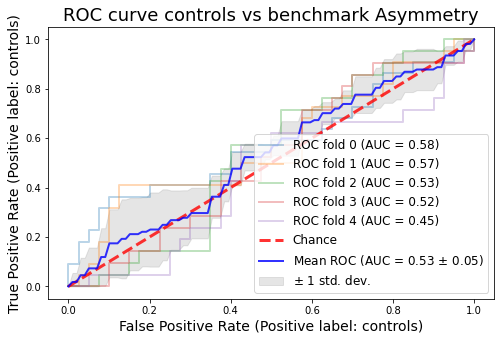

Accuracy: 0.592 (0.059)


In [90]:
X_train, X_test, y_train, y_test = train_test_split(X_all, labels_left, test_size=0.4, stratify=labels_left, random_state=42)

fig, ax = plt.subplots(figsize=(8, 5))

cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
i = 0

for train_ix, test_ix in cv_outer.split(X_all, labels_left):
    X_train, X_test = X_all[train_ix, :], X_all[test_ix, :]
    y_train, y_test = labels_left[train_ix], labels_left[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = GradientBoostingClassifier(random_state=1)
    space = dict()
    space['loss'] = ['deviance', 'exponential']
    space['learning_rate'] = [0.05, 0.1, 0.2, 0.25]
    space['n_estimators'] = [50, 75, 100, 150]
    space['criterion'] = ['friedman_mse', 'squared_error', 'mse']
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = metrics.accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        
    viz = metrics.plot_roc_curve(best_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    i += 1 
    
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large')
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark Asymmetry', fontsize=18)
plt.show()
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

In [91]:
df_encoded_left = pd.merge(df_encoded_left, left_info,
                          left_on='sub',
                          right_on='subjects')

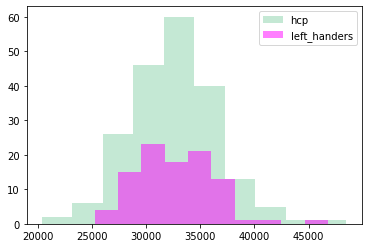

In [92]:
plt.subplot()
plt.hist(df_encoded_hcp_X.loss, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_left.loss, color='magenta', alpha=0.5, label='left_handers')
plt.legend()